In [1]:
print("start")
import os
import sys
import pandas as pd
import numpy as np
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import MicrobiomeIsolationForest
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import copy
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu
from sklearn import ensemble
from sklearn.metrics import roc_auc_score
from scipy.spatial import distance
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.ensemble import IsolationForest
import datetime

from joblib import Parallel, delayed
from multiprocessing import cpu_count

from sklearn.mixture import GaussianMixture
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_auc_score

import warnings
from matplotlib.ticker import FuncFormatter

warnings.simplefilter(action='ignore', category=FutureWarning)


start


In [2]:
def read_files(location, sample_size, num_of_outliers):
    dataset_res = {outlier_num : pd.read_csv(location + "_50_%i.csv" % outlier_num, index_col=0) for outlier_num in num_of_outliers}
    dataset_res = {outlier_num: dataset_res[outlier_num][(dataset_res[outlier_num]["weights"] == "equal") & (dataset_res[outlier_num]["pc_method"] == "proportion") & (dataset_res[outlier_num]["replacement"] == True) & (dataset_res[outlier_num]["subsample_size"] == sample_size)] for outlier_num in dataset_res.keys()}
    return dataset_res

def add_auc(res_dict, dataset, all_res_auc = None):
    if all_res_auc is None:
        all_res_auc = pd.DataFrame(columns = ["dataset", "mifo_iso", 
                                              "num_of_anomalies", "score", "percentage"])
    
    for anomaly_num in res_dict:
        for anomaly_prec in set(res_dict[anomaly_num]["anomaly_percentage"]):
            tmp_dict = {"dataset": dataset, "mifo_iso": "mifo", "num_of_anomalies": anomaly_num, 
                "score": roc_auc_score(res_dict[anomaly_num][res_dict[anomaly_num]["anomaly_percentage"] == anomaly_prec]["anomaly"], 
                                       res_dict[anomaly_num][res_dict[anomaly_num]["anomaly_percentage"] == anomaly_prec]["score"]),
                                      "percentage": anomaly_prec}
            all_res_auc = pd.concat([all_res_auc, pd.DataFrame.from_dict(tmp_dict, orient = "index").T], ignore_index=True)
        
            tmp_dict = {"dataset": dataset, "mifo_iso": "iso", "num_of_anomalies": anomaly_num, 
                    "score": roc_auc_score(res_dict[anomaly_num][res_dict[anomaly_num]["anomaly_percentage"] == anomaly_prec]["anomaly"], 
                                       res_dict[anomaly_num][res_dict[anomaly_num]["anomaly_percentage"] == anomaly_prec]["iso"]),
                                      "percentage": anomaly_prec}
            all_res_auc = pd.concat([all_res_auc, pd.DataFrame.from_dict(tmp_dict, orient = "index").T], ignore_index=True)

            tmp_dict = {"dataset": dataset, "mifo_iso": "CLOUD", "num_of_anomalies": anomaly_num, 
                    "score": roc_auc_score(res_dict[anomaly_num][res_dict[anomaly_num]["anomaly_percentage"] == anomaly_prec]["anomaly"], 
                                       res_dict[anomaly_num][res_dict[anomaly_num]["anomaly_percentage"] == anomaly_prec]["CLOUD_score"]),
                                      "percentage": anomaly_prec}
            all_res_auc = pd.concat([all_res_auc, pd.DataFrame.from_dict(tmp_dict, orient = "index").T], ignore_index=True)
    return all_res_auc

def add_depth(res_dict, dataset, all_res_depth = None):
    
    for anomaly_num in res_dict.keys():
        tmp_res = copy.deepcopy(res_dict[anomaly_num])
        tmp_res["anomaly_num"] = anomaly_num
        tmp_res["dataset"] = dataset
        if all_res_depth is None:
            all_res_depth = tmp_res
        else:
            all_res_depth = pd.concat([all_res_depth,tmp_res], ignore_index = True)
    return all_res_depth

In [3]:
res_franzosa = read_files("franzosa/contamination_test/mini_franzosa_results", 100, [1, 2,3, 4, 5, 10, 15, 20, 25])
res_mp_m3 = read_files("caporaso/contamination_test/mini_mp_results_M3_normal", 10, [1, 2,3, 4, 5, 10, 15, 20, 25])
res_mp_f4 = read_files("caporaso/contamination_test/mini_mp_results_F4_normal", 10, [1, 2,3, 4, 5, 10, 15, 20, 25])

res_hmp = read_files("hmp/contamination_test/mini_hmp_results", 150, [1, 2,3, 4, 5, 10, 15,20, 25])
res_wang = read_files("wang/contamination_test/results/mini_wang_results", 100, [1, 2,3, 4, 5, 10, 15, 20, 25])

In [4]:
auc_df = add_auc(res_franzosa, "franzosa")
depth_df = add_depth(res_franzosa, "franzosa")

auc_df = add_auc(res_mp_m3, "mp_m3", auc_df)
depth_df = add_depth(res_mp_m3, "mp_m3", depth_df)

auc_df = add_auc(res_mp_f4, "mp_f4", auc_df)
depth_df = add_depth(res_mp_f4, "mp_f4", depth_df)


auc_df = add_auc(res_hmp, "hmp", auc_df)
depth_df = add_depth(res_hmp, "hmp", depth_df)

auc_df = add_auc(res_wang, "Wang", auc_df)
depth_df = add_depth(res_wang, "Wang", depth_df)

depth_df.reset_index(drop=True, inplace=True)
auc_df["anomaly_precentage"] = auc_df["num_of_anomalies"] * 2
depth_df["anomaly_precentage"] = depth_df["anomaly_num"] * 2

auc_df[auc_df["dataset"] == "hmp"]
auc_df.replace("mifo", "KADAIF", inplace = True)
auc_df.replace("iso", "IF", inplace = True)

auc_df.columns = ["dataset", "Method", "num_of_anomalies", "AUC", "Contamination Percentage", "Anomaly Percentage"]
auc_df = auc_df.replace("franzosa", "Franzosa").replace("yachida", "Yachida").replace("hmp", "HMP").replace("mp_m3", "Caporaso M3").replace("mp_f4", "Caporaso F4")
depth_df = depth_df.replace("franzosa", "Franzosa").replace("yachida", "Yachida").replace("hmp", "HMP").replace("mp_m3", "Caporaso M3").replace("mp_f4", "Caporaso F4")

auc_df["Contamination Percentage"] = (auc_df["Contamination Percentage"] * 100).astype(int)

<Figure size 1000x2000 with 0 Axes>

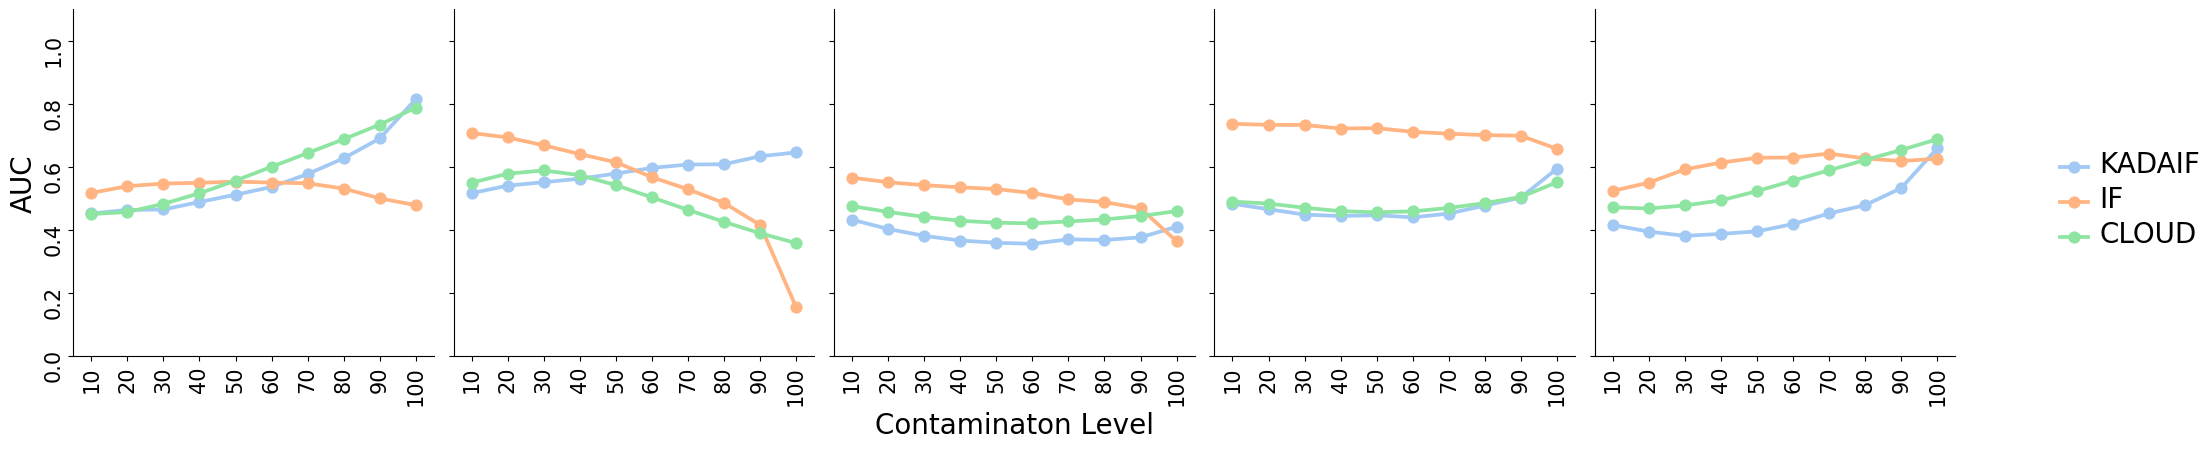

In [13]:
cur_anomaly_perc = 50

tmp_auc_df = auc_df[auc_df["Anomaly Percentage"] == cur_anomaly_perc]
tmp_auc_df = tmp_auc_df[tmp_auc_df["Contamination Percentage"] > 0]

plt.figure(figsize=(10,20))
g = sns.catplot(x="Contamination Percentage", y="AUC", hue="Method", col="dataset", kind = "point",
                aspect=0.75, palette = "pastel", errorbar = None, col_order= ["Franzosa", "HMP", "Caporaso M3", "Caporaso F4", "Wang"],
               data=tmp_auc_df)


if cur_anomaly_perc <= 4:
    g.set_titles("{col_name}", size=20)  # Here, 'col_name' will be replaced by the value of the dataset column
else:
    g.set_titles("", size=20)


# Increase the font size for the axis ticks
counter = 0
for ax in g.axes.flat:
    ax.tick_params(labelsize= 15, rotation  = 90)  

    
    # Increase the axis title size
      # Set the size of the x-axis title
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
    if counter == 2:
        ax.set_xlabel("Contaminaton Level", fontsize=20)
    else:
        ax.set_xlabel("", fontsize=0)
    counter += 1
    ax.set_ylim(0,1.1)


plt.ylabel("AUC", fontsize = 20)
    
g._legend.set_title("", prop={'size': 0})
for text in g._legend.texts:
    text.set_fontsize('20')  # Set text fontsize
g._legend.set_bbox_to_anchor((1.12, 0.5))

g.fig.suptitle("" , fontsize=30)
g.fig.tight_layout(rect=[0, 0, 1, 0.95])

    
